<a href="https://colab.research.google.com/github/frapasti/Human-Hands/blob/main/Yolo_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #TODOs
* Find the best architecture on a small dataset
* Create a batch generation function in order to not fill the memory of Colab
* Train the best architecture on the new batch generator







# IMPORTS

* Import all the needed libraries for the notebook
* Mount the drive containing the datasets
* Unzip the a small part of the dataset







In [1]:
!pip install natsort
import os
from natsort import natsorted
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import imutils
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from math import trunc

from keras.models import Sequential 

from keras.layers.core import Dense, Dropout, Activation 
from keras.utils import np_utils
from keras.layers import LeakyReLU   
from keras.regularizers import l2  
from tensorflow import keras
from keras.models import Model                   

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

from google.colab import drive
drive.mount('/content/drive')

!unzip drive/My\ Drive/Datasets/egoHands.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data organization for YOLO

Get all the bboxes path and all the img_paths
Additionally read all the text files corresponding to the bounding boxes and append them to a list.
**bboxes** contains lists of bounding boxes, one per image

In [4]:
#Get from the unzipped dataset the list of all the paths of images and txt files
#listdir returns unsorted so use natsorted method!
bboxes_paths = natsorted(listdir_fullpath('/content/egoHands/boundingboxes'))
img_paths = natsorted(listdir_fullpath('/content/egoHands/frames'))

assert len(bboxes_paths) == len(img_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

#Read all the text files and create a list of list of bounding boxes, one list per image 
bboxes = []*len(bboxes_paths)
for path in bboxes_paths:
  bboxes_it = []
  file = open(path, 'r')
  Lines = file.readlines()
  for line in Lines:
    bboxes_it.append([int(x) for x in line.split(',')])
  bboxes.append(bboxes_it)

The following cell scale down every image to have a size of 416x416 as required by the input of the network and appends the new images arrays to **scaled_images**.

Additionally it performs some modifications to the bounding boxes, transforming them from the original format to the 416x416 format and creating the list **scaled_bboxes**

**N.B.** Depending on number of images it may require some time

In [5]:
n_imgs_toload = 500 # Not loading all the unzipped images otherwise memory problem with colab
scale = n_imgs_toload/len(img_paths)
scaled_bboxes = []*int(len(bboxes_paths)*scale)
scaled_images = []*int(len(img_paths)*scale)
for i in range(0,int(len(img_paths)*scale)):
  # store the original image parameters
  original_img = load_img(img_paths[i])
  width, height = original_img.size
  # load the image with the required size and calculate scale factors
  image = load_img(img_paths[i], target_size=(448, 448))
  scale_w = 448 / width 
  scale_h = 448 / height
  # for each bounding box of the image calculate its correspondent one in 416x416 format  
  bboxes_it = []
  for box in bboxes[i]:
    xleft = int(box[0] * scale_w)
    yleft = int(box[1] * scale_h)
    b_width = int(box[2] * scale_w)
    b_height = int(box[3] * scale_h)
    new_bbox = [xleft,yleft,b_width,b_height]
    bboxes_it.append(new_bbox)
  scaled_bboxes.append(bboxes_it)
  # convert the image to the array format required by the CNN
  image = img_to_array(image)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  scaled_images.append(image)

**TESTING** :
In the following cell, some testing can be performed to visualize the scaled down version of the image and the corresponding scaled down bounding box. Just change the variable *number* to see different results

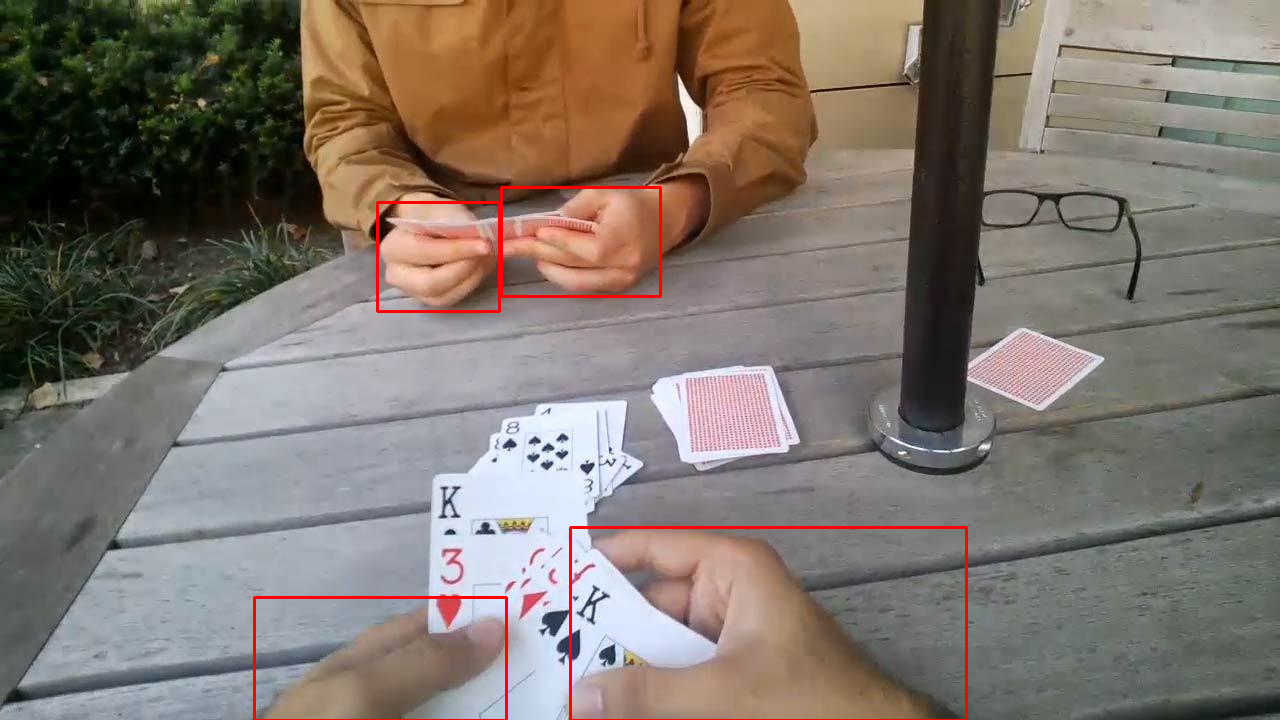

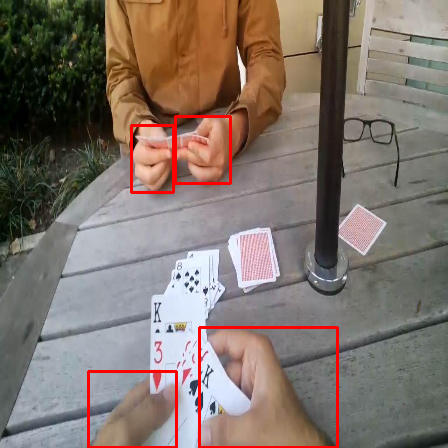

In [6]:
number = 123 #number of the image to be loaded

image = cv2.imread(img_paths[number])
      
# Drawing the regions in the Image
for (x, y, w, h) in bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
cv2_imshow(image) 

image = cv2.imread(img_paths[number])
      
# Resizing the Image
image = cv2.resize(image,(448,448))

# Drawing the regions in the Image
for (x, y, w, h) in scaled_bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
  
cv2_imshow(image)

Now create the grid of cells that Yolo analyzes.
The size of the grid is 8x8 meaning that each cell will have a size of 52x52.

For each bounding box calculate its center, the center will be the grid at which the bounding box is associated.
Each grid cell has a bounding box associated with it (zero if no bounding box). The bounding box has this form [P, Ox, Oy, W, H]:


*   P = probability that there's a hand (always 1 since we are taking ground truth boxes)
*   Ox = X center of the bounding box w.r.t to that grid, each grid has coordinates defined by (0,0) and (1,1) being respectively the up-left and down-rigth corner of such grid
*   Oy = Y center with same reasoning as above
*   W = width of the bounding box w.r.t the grid size
*   H = height of the bounding box w.r.t. the grid size

So, as an example, a bounding box b = [208,208,104,104] will be associated to the cell at row = 3 and column = 3 and become b_new = [1 ,0.5 ,0.5 , 2, 2]



In [6]:
S = 7 # number of grids, if for example S = 8 the image will be divided into a frid 8x8
cell_size = 448/S # Number of pixels per cell
Y_train = []*len(scaled_bboxes) # Ground truth of the network the size is 8x8(Grid)x5(One bounding box with associated prob per cell) for each image
# Iterate over all the scaled boxes 
for i in range(0,len(scaled_bboxes)):
  Y_net = np.zeros((S,S,5))
  for (x, y, w, h) in scaled_bboxes[i]:
    # Calculate the coordinates of the center of the bbox w.r.t the whole image
    ox = x + w/2
    oy = y + h/2
    # Calculate the coordinates of the cell in the grid that contains the center 
    grid_col = trunc(ox/cell_size) # - 1 because the coordinates are from 0 to S - 1 not from 1 to S
    grid_row = trunc(oy/cell_size) 
    # Calculate the coordinates of the center of the bbox w.r.t the associated cell; (0,0) top left and (1,1) bottom right corners of the cell
    ox_cell = (ox - (grid_col)*cell_size)/cell_size
    oy_cell = (oy - (grid_row)*cell_size)/cell_size
    # Calculate the width and height of the bbox in terms of cell size, a bbox of width 448/S(cell size) will have grid_width = 1
    grid_width = w/cell_size
    grid_heigth = h/cell_size
    # Put the results into y; 1 represent the probability of the class
    y = [1,ox_cell,oy_cell,grid_width,grid_heigth]
    #Put y in the correct position of the ground truth
    Y_net[grid_row][grid_col] = y
  Y_train.append(Y_net)

In [8]:
# Division of the images in test and train to evaluate the model

X = np.array(scaled_images) # Needed because list are not accepted as input by model.fit
Y = np.array(Y_train)

X_train = X[0:450]
Y_train = Y[0:450]

X_test = X[450:500]
Y_test = Y[450:500]

print("X train shape : " + str(X_train.shape))
print("Y train shape : " + str(Y_train.shape))
print("X test shape : " + str(X_test.shape))
print("Y test shape : " + str(Y_test.shape))

# LOSS FUNCTION
Definition of the loss function as the one used in the paper but simpler.

There are just 5 parameters for each cell [P, x, y, w, h] thus one bounding box per cell.

Hence penalize the sum square root of x,y,(w)^1/2,(h)^1/2 as in the paper but just for the cells that contain a box so those with P = y_true[0] = 1.

Then penalize the sum square root of P.

Then penalize the sum square root of P for the cells that do not contain boxes hence with P = y_true[0] = 0.


In [14]:
def custom_loss(y_true, y_pred):
  
  # y_true (Batch size, 7, 7, 5)
  # y_pred (Batch size, 7, 7, 5)
  mse = tf.keras.losses.MeanSquaredError(reduction = "sum") # Define the SUM squared error loss
  predictions = tf.reshape(y_pred,(-1,7,7,5)) # The predictions are a tensor, need some reshaping to manipulate it

  exists_box = tf.expand_dims(y_true[...,0], 3) # A box exists if the first entry of the cell is equal to 1 

  #------------#
  #| BOX LOSS |#
  #------------#

  pred_box = exists_box*predictions[...,1:5] #Calculate only loss for the cells that contain a box
  target_box = exists_box*y_true[...,1:5] #Target boxes

  epsilon = tf.fill(pred_box[..., 2:4].shape, 1e-6) #Needed to avoid divergence of square root derivatives in back propagation

  # width and height are penalyzed using the square root, however predictions can be negative so multiply by sign in order to obtain positive
  # and take absoulte value in the square root 
  wh_pred = tf.math.sign(pred_box[...,3:5]) * tf.math.sqrt(tf.math.abs(pred_box[...,3:5] + epsilon))
  wh_targ = tf.math.sqrt(target_box[...,3:5] + epsilon)

  # Get also centers
  xy_pred = pred_box[...,1:3]
  xy_true = target_box[...,1:3]

  # Concatenate the new xy and wh in order to calculate sum squared root
  final_pred_box = tf.concat([xy_pred,wh_pred], axis = 3)
  final_true_box = tf.concat([xy_true,wh_targ], axis = 3)
  box_loss = mse(tf.reshape(final_pred_box, (-1, final_pred_box.shape[-1])),tf.reshape(final_true_box, (-1, final_true_box.shape[-1])))
  

  #---------------#
  #| OBJECT LOSS |#
  #---------------#
  
  # Take only the first entry of each box corresponding to the probability that there's an object
  pred_obj = predictions[...,0:1]
  true_obj = y_true[...,0:1]

  #Calculate object loss as in the paper
  object_loss = mse(tf.reshape(exists_box*pred_obj, (-1, )), tf.reshape(exists_box*true_obj, (-1, )) )

  #------------------#
  #| NO OBJECT LOSS |#
  #------------------#

  # Calculate the loss for cells that don't have objects
  non_exists_box = 1 - exists_box
  no_object_loss = mse(tf.reshape(non_exists_box*pred_obj, (-1, )), tf.reshape(non_exists_box*true_obj, (-1, )))

  #--------------#
  #| FINAL LOSS |#
  #--------------#

  # Penalize more the box loss and less the no object loss   
  total_loss = 5*box_loss + object_loss + 0.5*no_object_loss
  return total_loss

In [15]:
# Test that the loss function works returning a numpy number
x = tf.random.uniform((2, 7, 7, 5))
y = tf.random.uniform((2, 7, 7, 5))
custom_loss(x,y)

<tf.Tensor: shape=(), dtype=float32, numpy=26.953463>

# **!!READ ME!!**

In order to evaluate you need to compile only one of the following three sections! In each of them there's a different model but all of them are called Yolo


1.   Best architecture so far already trained
2.   Best architecture so far not trained!
3.   Custom architecture based on a Pre-trained model
4.   Custom architecture

For trial change section 3, if such architecure is better than 1 go on and change 1 :) 



# 1. Best architecture (already trained)
Compile to have best architecture so far:

* Number of parameters : 221144885
* Loss : 
* Accuracy : 

In [ ]:
tf.keras.backend.clear_session()
yolo = keras.models.load_model('/content/drive/MyDrive/YOLO_best')
yolo.summary()

#2. Best architecture

It contains the skeleton of the best architecture so far, if you compile the cell all the weights will be randomly initialized so it needs training

In [ ]:
tf.keras.backend.clear_session()

yolo = Sequential()
lrelu = LeakyReLU(alpha=0.1)

yolo.add(tf.keras.layers.Conv2D(32, (7, 7), padding="same", activation = lrelu, strides = (1,1), input_shape=(448,448,3), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4) ))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(128, (1, 1), padding="same", activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(512, (1, 1), padding="same", activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.Conv2D(1024, (3, 3), padding="same", activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(1024, (3, 3), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4)))


yolo.add(tf.keras.layers.Reshape((50176,), input_shape=(14,14,64)))

yolo.add(Dense(4096))

yolo.add(Dense(245))

yolo.add(tf.keras.layers.Reshape((7,7,5), input_shape=(245,)))


yolo.summary()

# 3. Custom architecture Pretrained model

To load a pre-trained CLASSIFICATION model trained on Yolo_pretraining.ipynb.

The next cells load the customly train your CNN classification model on the notebook and then pop the last few layers and replace them with the new YOLO layers for regression

In [182]:
tf.keras.backend.clear_session()
yolo_pretrained = keras.models.load_model('/content/drive/MyDrive/YOLO_pretrained')
yolo_pretrained.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 32)    4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    4160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 64)   0

In [187]:
from keras.models import Model

yolo = Sequential()

classif_yolo = Model(yolo_pretrained.input, yolo_pretrained.layers[-4].output) #Pop the last three classification layers used by pre trained model

yolo.add(classif_yolo)
yolo.add(tf.keras.layers.Reshape((3136,), input_shape=(7,7,64)))


for layer in yolo.layers[:]:
    layer.trainable = False

layer1 = Dense(245, activation = 'sigmoid')
yolo.add(layer1)
layer1.trainable = True

layer2 = tf.keras.layers.Reshape((7,7,5), input_shape=(245,))
yolo.add(layer2)
layer2.trainable = True

for layer in yolo.layers:
  print(layer, layer.trainable)

yolo.summary()

<keras.engine.functional.Functional object at 0x7f1a85118990> False
<keras.layers.core.reshape.Reshape object at 0x7f1a85118410> False
<keras.layers.core.dense.Dense object at 0x7f1a85191dd0> True
<keras.layers.core.reshape.Reshape object at 0x7f1a86f3dd90> True
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, None, None, 64)    27392     
                                                                 
 reshape_4 (Reshape)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 245)               768565    
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 5)           0         
                                                                 
Total params: 795,957
Trainable params: 768,565
Non-tra

# 4. Custom architecture
For trials and to hopefully replace 1. ;)

In [ ]:
tf.keras.backend.clear_session()


yolo = Sequential()
lrelu = LeakyReLU(alpha=0.1)

yolo.add(tf.keras.layers.Conv2D(32, (7, 7), padding="same", activation = lrelu, strides = (1,1), input_shape=(448,448,3), kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4) ))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Conv2D(64, (1, 1), padding="same", strides = (2,2), activation = lrelu, kernel_regularizer=l2(5e-4)))
yolo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides = (2,2), padding = 'same'))

yolo.add(tf.keras.layers.Reshape((12544,), input_shape=(14,14,64)))

yolo.add(Dense(245))

yolo.add(tf.keras.layers.Reshape((7,7,5), input_shape=(245,)))


yolo.summary()

# TRAINING
Perform the training of the model (don't need to run this cell if you loaded the already trained architecture in 1. !)

In [24]:
yolo.compile(loss=custom_loss, optimizer='adam', metrics = ['accuracy'])

In [ ]:
history = yolo.fit(X_train, Y_train, batch_size=25, epochs=50, verbose=1)

Epoch 1/50
18/18 [==============================] - 487s 27s/step - loss: 9563.7119 - accuracy: 0.1823
Epoch 2/50
18/18 [==============================] - 555s 31s/step - loss: 274.2745 - accuracy: 0.1400
Epoch 3/50
18/18 [==============================] - 478s 26s/step - loss: 62.6095 - accuracy: 0.0893
Epoch 4/50
18/18 [==============================] - 500s 28s/step - loss: 35.8197 - accuracy: 0.0906
Epoch 5/50
18/18 [==============================] - 483s 27s/step - loss: 33.9100 - accuracy: 0.0952
Epoch 6/50
18/18 [==============================] - 502s 28s/step - loss: 34.2305 - accuracy: 0.0900
Epoch 7/50
18/18 [==============================] - 485s 26s/step - loss: 31.6789 - accuracy: 0.0898
Epoch 8/50
18/18 [==============================] - 503s 28s/step - loss: 27.6353 - accuracy: 0.0898
Epoch 9/50
 5/18 [=======>......................] - ETA: 5:44 - loss: 30.3318 - accuracy: 0.0913

In [ ]:
#Some plots for the training!

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# TESTING
Get some performance metrics for the model and visualize how it works in some test images

In [167]:
#Function to transform the output of the network in the correct format
def decode_net_out(out):
  #out has shape 7x7x5
  #For each cell get the bounding boxes
  bboxes = []
  for i in range(0,7):
    for j in range(0,7):
      if out[i][j][0] > 0.5:
        bbox = np.zeros((4))
        ox_cell = out[i][j][1]
        oy_cell = out[i][j][2]
        w_cell = out[i][j][3]
        h_cell = out[i][j][4]
        if(ox_cell != 0 and oy_cell !=0):
          ox = trunc(ox_cell*cell_size + cell_size*j)
          oy = trunc(oy_cell*cell_size + cell_size*i)
          w = w_cell*cell_size
          h = h_cell*cell_size
          lx = ox - w/2
          ly = oy - h/2
          bbox = [int(lx),int(ly),int(w),int(h)]
          bboxes.append(bbox)
  return bboxes

(448, 448, 3)
(1, 448, 448, 3)


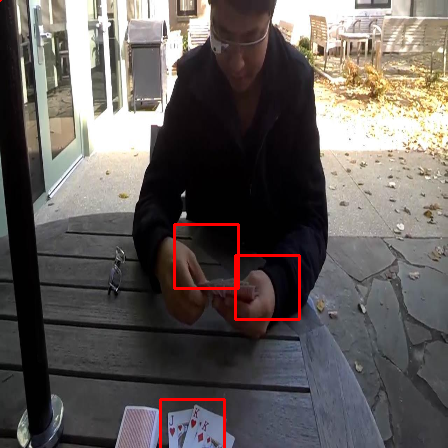

In [203]:
#Change the number to visualize results on new images 
number = 4

image = cv2.imread(img_paths[450 + number])
image = cv2.resize(image,(448,448))

in_net = load_img(img_paths[number], target_size=(448, 448))
in_net = X_test[number]
in_net = np.expand_dims(in_net, axis=0) #Expand dimension because the network work with batches as input

out_net = yolo.predict(in_net)
out_bboxes = decode_net_out(out_net[0])

# Drawing the regions in the Image
for (x, y, w, h) in out_bboxes:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
cv2_imshow(image) 

# IF YOU FOUND A BETTER MODEL
Run this cell after creating a new google drive folder to save the new best model

In [150]:
yolo.save('/content/drive/MyDrive/YOLO1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/YOLO1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/YOLO1/assets
